In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
import matplotlib
from matplotlib import pyplot as plt
import ngfunction

In [25]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=73, ombh2=0.023, omch2=0.111)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
#trovo densità diverse...
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [26]:
pars.set_matter_power(redshifts=[0.7], kmax=1.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

In [27]:
kh, z, pk = results.get_matter_power_spectrum(minkh=2e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza

In [28]:
H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

def dist(z):   #funzione per trasformare il redshift in distanza
    return results.comoving_radial_distance(z) #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

In [29]:
om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(1+z[0])**3/(H(z[0])/H0)**2 #densità di materia a diverso z
omz

0.6210583881231838

In [30]:
bias = 1 + z[0]*0.84   #funzione di bias delle galassie, cercane altre!!

f = (results.get_fsigma8()/results.get_sigma8())
dl = results.luminosity_distance(z[0])
d= results.comoving_radial_distance(z[0])
 

fl= (2*d/(1+z[0]))/(d+(1+z[0])*2.99e5/H(z[0]))

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati

In [31]:
Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        Pgg[i][j] = float((bias + fl *f * mu[j]**2)*(bias + f * mu[j]**2)*pk[:,i])


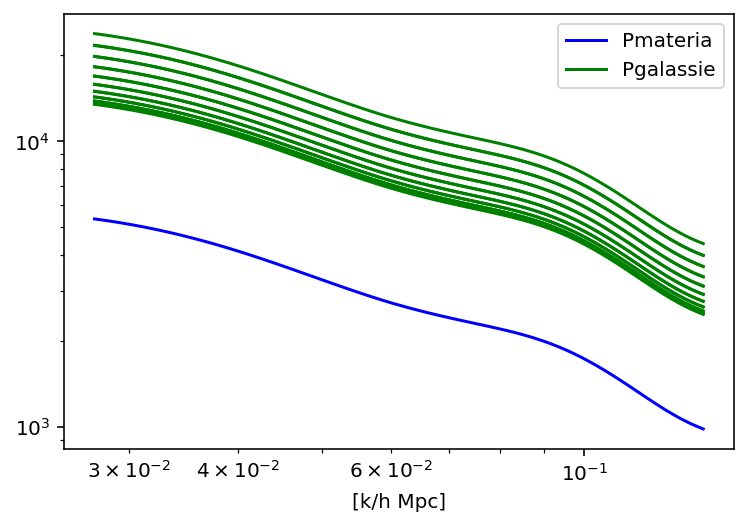

In [32]:
fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(kh, pk[0,:], color='b', ls = '-')
for i in range(len(mu)):
    ax.plot(kh, Pgg[:,i], color='g', ls ='-')  #aggiungi gli errori

plt.legend(['Pmateria', 'Pgalassie'])

In [33]:
##Errori dei dati simulati
ng= ngfunction.Ng(z[0])*10**4/h**3   #mean galaxy number density for z near 0 (Euclid spettroscopy survey)
DeltaMu = np.abs(mu[0]-mu[1])
DeltaZ = 0.1
DeltaK = np.empty((len(kh)))

for i in range (len (kh)):
    if i==0 : DeltaK[i]= 2* np.abs(kh[i+1]-kh[i])
    elif i==len(kh)-1:
       DeltaK[i]= 2*np.abs(kh[i-1]-kh[i])
    else: DeltaK[i]= np.abs(kh[i+1]-kh[i])/2+ np.abs(kh[i-1]-kh[i])/2
    if(DeltaK[i]<1e-2): DeltaK[i]=1e-2   #l'intervallo deve comunque essere più grande di kmin, se non lo è lo metto uguale a kmin
    
N = np.empty((len(kh),len(mu)))
Vol = 4./3.*np.pi*((dist(z[0]+DeltaZ/2))**3-(dist(z[0]-DeltaZ/2)**3))    #calcolo il volume di cielo considerato, inmmagino di guardare il cielo su tutti gli angoli (ideale)

for j in range(len(kh)):
    N[j,:]= Vol/(2*np.pi)**3 * kh[j]**2*DeltaMu*DeltaK[j]  #uguale per tutte le mu

err_Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        err_Pgg[i][j] = np.sqrt(2/N[i][j])*(Pgg[i][j]+1/ng)


In [34]:
#cerco la distanza minima, per risalire il kmin da mettere all'inizio del codice

kmin= 2*np.pi/(dist(z[0]+DeltaZ/2)-dist(z[0]-DeltaZ/2))
kmin*h

0.015750493585308428

In [35]:
#calcolo il chi quadro per un certo set di valori di gamma
gammas= np.arange(0.48,0.6,0.005)   

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi2 = np.zeros(len(gammas))


for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2[k]= chi2[k]+(float((bias + (omz**gamma)*fl * (mu[j])**2)*(bias + (omz**gamma)* (mu[j])**2)*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2

Text(0, 0.5, 'Chi^2')

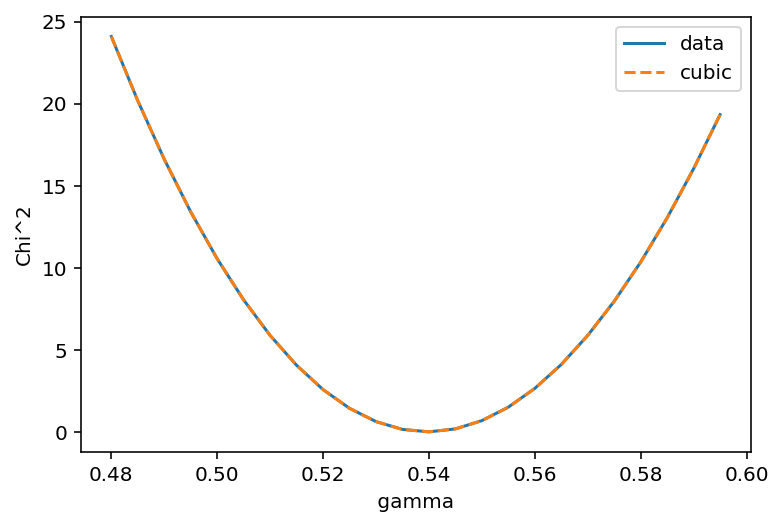

In [36]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol =  interpolate.interp1d(gammas,chi2,kind='cubic')
plt.plot(gammas,chi2,'-', gammas, interpol(gammas), '--')
plt.legend(['data', 'cubic'])
plt.xlabel(' gamma ')
plt.ylabel('Chi^2')

In [37]:

y=lambda x: interpol(x)
minimo = optimize.least_squares(y,0.5)
min1= float(minimo.x)
minimo

 active_mask: array([0.])
        cost: 7.739227243981837e-16
         fun: array([3.9342667e-08])
        grad: array([-1.28436727e-09])
         jac: array([[-0.03264566]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 15
        njev: 15
  optimality: 1.2843672666189359e-09
      status: 1
     success: True
           x: array([0.53975069])

In [38]:
chi2min= y(min1)

Text(0, 0.5, 'Chi^2')

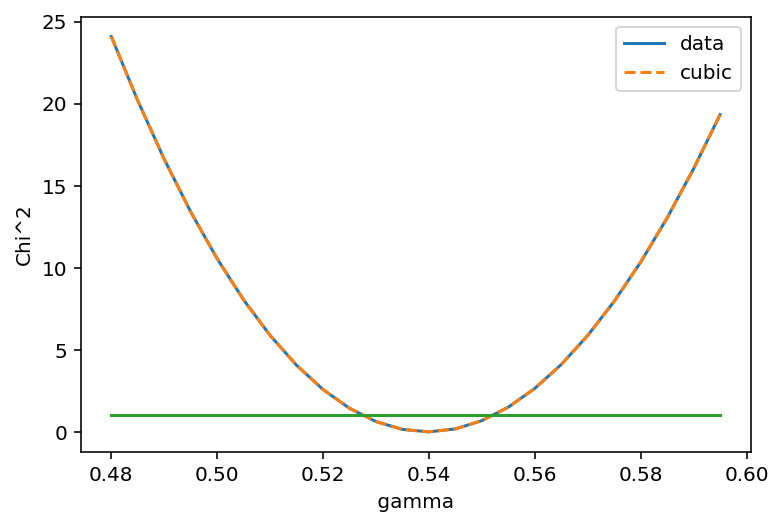

In [39]:
#devo scalare il grafico
plt.plot(gammas,chi2-chi2min,'-', gammas, interpol(gammas)-chi2min, '--')
plt.legend(['data', 'cubic'])

#CALCOLO DELL'ERRORE
xpoints= np.arange(0.48,0.6,0.005)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)

plt.xlabel(' gamma ')
plt.ylabel('Chi^2')


In [40]:
y2= lambda x: interpol(x) - 1 -chi2min
error1 = optimize.brentq(y2,0.48,min1)    #trova le soluzioni in un intervallo fissato
error2 = optimize.brentq(y2,min1,0.58)
print(error1,error2)

0.5274182142359144 0.55217262144107


In [41]:
print(np.abs(min1-error1))
print(np.abs(min1-error2))

sigma = 0.02

0.012332471266543021
0.012421935938612627


In [42]:
interpol3= interpol